<div style="text-align: left;">
<table style="width:100%; background-color:transparent;">
  <tr style="background-color:transparent;">
    <td style="background-color:transparent;"><a href="http://www.datascience-paris-saclay.fr">
<img border="0" src="http://project.inria.fr/saclaycds/files/2017/02/logoUPSayPlusCDS_990.png" width="90%"> </td>
     <td style="background-color:transparent;"><a href="https://www.sidetrade.com/">
<img border="0" src="https://www.sidetrade.com/wp-content/uploads/22050384_10213210110060640_1095182809_o-300x117.png" width="60%"> </td>
  </tr>
</table> 
</div>

<center><h1>FAN revenue prediction challenge</h1></center>
<br/>
<center>Lucy Liu (CDS), Maria Teleczuk (CDS), Clément Chastagnol (Sidetrade),<br /> Gael Varoquaux (Inria, Parietal), Alex Gramfort (Inria, Parietal), Guillaume Lemaitre (Scikit-learn @ Inria Foundation)</center>

Predicting revenue using French Attribution Notices: [RAMP studio challenge](https://ramp.studio/problems/fan_revenue_prediction)

## Table of Contents

0. [Introduction](#Introduction)
1. [Data](#Data)
3. [Score metric](#Score-metric)
4. [Data exploration](#Data-exploration)
5. [Predictions](#Predictions)
6. [Record linkage](#Record-linkage)
7. [Submission structure](#Submission-structure)
8. [Local testing](#Local-testing-(before-submission))
9. [Submitting to RAMP studio](#Submitting-to-[ramp.studio](http://ramp.studio))
10. [More information](#More-information)

# Introduction

The objective of this challenge is to work with 'dirty data'. Most real data is dirty and the availability of high-quality, open-source ML and data analysis frameworks (such as [scikit-learn](https://scikit-learn.org/),
[pandas](https://pandas.pydata.org/)...) means that the next frontier for tooling and automation lies in preprocessing. This challenge aims to investigate methodologies to perform statistical analysis directly on the original dirty data.

There are two datasets in this challenge:

* `company_revenue_TRAIN.csv` - company revenue declarations.
* `award_notices_RAMP.csv` -  French Attribution Notices.

# Aim

The predictive aim of this challenge is to use `company_revenue_TRAIN.csv` and `award_notices_RAMP.csv` to predict the Revenue for each entry in the 'company financial data' dataset. It is advised that you use both datasets, as it improves the prediction (see [Score comparison](#Score-comparison)), but using only the `company_revenue_TRAIN.csv` dataset is also allowed.

# Data

## Company financial data

This dataset was built from an extract of the [National Institute of Statistics and Economic Studies (INSEE)](https://www.insee.fr/en/accueil) reference database of company revenue declarations from 2013 to 2018. Each row represents the declaration of one company for one year and the following information is provided in the columns:

* `Legal_ID` - the reconcilled legal ID of the company
* `Name` - the name of the company
* `Activity_code (APE)` - 'Activite Principale de l'Entreprise', the main activity of the company - more information in [English](https://www.startbusinessinfrance.com/code-ape) or in [French](https://www.service-public.fr/professionnels-entreprises/vosdroits/F33050)
* `Address` 
* `Zipcode`
* `City`
* `Revenue` - in Euros
* `Headcount`
* `Fiscal_year_end_date`
* `Fiscal_year_duration_in_months`
* `Year`

There are a few things to note:

* there are revenue declarations for the same company but different years
* there is a large reduction in entries for the years 2017 and 2018 due to the Loi Macron law in 2017
* the 'same company' can have several different entities, resulting in entries where the `Legal_ID` is different but the `Name`, `Address`, `City` and `Zipcode` are all the same.
* `Revenue` can be negative. A negative revenue may be due to cancelled orders from the previous fiscal year that was recorded in the current fiscal year.


## Award notices

Every French public organisation has to issue a call for tenders when buying supplies or services (above a minimum threshold). These are called public procurement contracts. Companies then compete anonymously on these contracts and when a bid is awarded, a notice has to be legally published by the public organization on the [BOAMP](https://www.boamp.fr/) (historical data is hosted by the [DILA](https://www.dila.premier-ministre.gouv.fr/)). These are called French Attribution Notices (FAN). About 25% of awards are actually electronically published.

Each contract can be divided into a maximum of 5 lots and the same company can win >1 lot of a contract. The award notices dataset comprises award notices from 2017 and 2018. Each row refers to one lot and there can be up to 5 lots referring to the same contract. The following information is provided for each lot:

* `ID_call` - ID of the award notice
* `Publication_date` of the award notice
* `End_of_call_date` of the award notice
* `Departments_of_publication` - the department code(s) of the award notice
* `Department_of_provision` - the department code(s) where the contract works/goods/services were provided 
* `Call_summary` - summary of the award notice
* `Call_title` - title of the award notice
* `Complete_call_description` - description of the award notice
* `Total_amount` - total amount of the contract, from all lots, in euros
* `CPV_classes` - Common Procurement Vocabulary (CPV), a classification system for public procurement used to describe the subject of procurement contracts (more information can be found [here](https://simap.ted.europa.eu/cpv))
Columns providing details about the company issuing the contract:
* `Buyer_name` 
* `Buyer_address`
* `Buyer_zipcode`
* `Buyer_city`
* `Buyer_email`
* `Buyer_URL`

* `Contract_awarded` - whether or not the contact was awarded

Columns providing details about the winner of each lot:

* `ID` - unique lot ID 
* `awarded` - whether or not the contact was awarded
* `description` - description of the lot
* `incumbent_name` - name of the lot winnter
* `incumbent_address` - address of the lot winner
* `incumbent_zipcode` - zipcode of the lot winner
* `incumbent_city` - city of the lot winner
* `incumbent_country` - country of the lot winner
* `number_of_received_bids` - number of bids this lot received
* `amount` - amount of the lot in euros

**Important notes**

Both data sets are very dirty. There is a lot of missing data and the column descriptions provided above are a guide only. Further, the award notices dataset is much smaller than the company revenue declarations dataset. Therefore, it is expected that many companies in the company revenue declarations dataset are not present in the award notices dataset.

## Training and test

The company revenue training dataset has been split into 'training' and 'test' subsets. The shapes are:

* training: (1 495 948, 11)
* test: (520 966, 11)

Your model will be tested on a completely separate company revenue dataset stored on the RAMP server. This dataset has a shape of (702 181, 11). This test dataset will also be dirty but we can guarantee that the following columns will (only) be of numerical data type:

* `Legal_ID`
* `Headcount`
* `Fiscal_year_duration_in_months`
* `Year`

# Score metric

A unique score is used:

$$score =  |max(5,log_{10}(max(1,y\_true))) - max(5,log_{10}(max(1,y\_pred)))| $$

Score interpretation:

* A lower score is better
* Any `y_true` or `y_pred` value less than 1 is 'taken' as 1
* If both the `y_true` and `y_pred` are less than 100 000, the score would be 0.
* The score is the same regardless of the order of `y_true` and `y_pred` in the equation.
* If the difference in raw `y_true` and `y_pred` values is the same, the score is greater for smaller magnitudes of `y_true` and `y_pred`.

# Data exploration

In [1]:
%matplotlib inline
import imp
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
import recordlinkage.preprocessing
from itertools import chain
from category_encoders.target_encoder import TargetEncoder

## Company financial data

In [3]:
from problem import get_train_data

X_df, y_array = get_train_data()

In [4]:
X_df.head(3)

,Legal_ID,Name,Activity_code (APE),Address,Zipcode,City,Headcount,Fiscal_year_end_date,Fiscal_year_duration_in_months,Year
0,582296,COMICOB,NaN,BOULOUPARIS BP 15 BOULOUPARIS,NaN,NaN,NaN,2016-12-31,12.0,2016.0
1,582981,CIANFARANI JEAN-MICHEL,NaN,33 AVENUE H. LAFLEUR - VICTOIRE - B.P. 4031 NO...,NaN,NaN,NaN,2016-12-31,12.0,2016.0
2,588541,OK POULET 5EME SARL,NaN,23 RUE PAUL BERT,98800.0,NOUMEA,1.0,2016-12-31,12.0,2016.0


In [5]:
X_df['Fiscal_year_end_date'] = pd.to_datetime(X_df['Fiscal_year_end_date'], format='%Y-%m-%d')

In [6]:
X_df.shape

(1495948, 10)

In [7]:
# proportion of NaN values
X_df.isna().sum() / X_df.shape[0]

Legal_ID                          0.000000
Name                              0.000002
Activity_code (APE)               0.012293
Address                           0.175296
Zipcode                           0.167944
City                              0.000313
Headcount                         0.637439
Fiscal_year_end_date              0.000000
Fiscal_year_duration_in_months    0.000000
Year                              0.000000
dtype: float64

In [8]:
# number of unique values
X_df.nunique()

Legal_ID                          563929
Name                              528646
Activity_code (APE)                  964
Address                           276152
Zipcode                             7471
City                               29498
Headcount                           2224
Fiscal_year_end_date                 300
Fiscal_year_duration_in_months         1
Year                                   6
dtype: int64

In [9]:
X_df.dtypes

Legal_ID                                   int64
Name                                      object
Activity_code (APE)                       object
Address                                   object
Zipcode                                  float64
City                                      object
Headcount                                float64
Fiscal_year_end_date              datetime64[ns]
Fiscal_year_duration_in_months           float64
Year                                     float64
dtype: object

In [10]:
X_df.describe()

,Legal_ID,Zipcode,Headcount,Fiscal_year_duration_in_months,Year
count,1.495948e+06,1.244713e+06,5.423720e+05,1495948.0,1.495948e+06
mean,5.060829e+08,5.464419e+04,8.736985e+01,12.0,2.014475e+03
std,1.417373e+08,2.755171e+04,9.002249e+03,0.0,1.246598e+00
min,5.822960e+05,6.000000e+00,-3.900000e+01,12.0,2.013000e+03
25%,4.149439e+08,3.185000e+04,1.000000e+00,12.0,2.013000e+03
50%,4.895445e+08,6.053000e+04,3.000000e+00,12.0,2.014000e+03
75%,5.293306e+08,7.511600e+04,9.000000e+00,12.0,2.015000e+03
max,9.999905e+08,9.889500e+04,5.450000e+06,12.0,2.018000e+03


### Distribution of Revenue

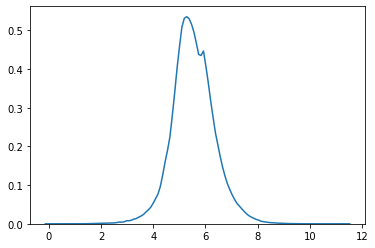

In [11]:
logRev = np.log10(np.clip(y_array, a_min=1, a_max=None))
seaborn.kdeplot(logRev)

## Award notices

We will use another dataset which can be usefull to predict the Revenue of a company

In [12]:
award = pd.read_csv('data/award_notices_RAMP.csv.zip', low_memory=False,
                    compression='zip')
award.head(3)

,CallID,Publication_date,End_of_call_date,Departments_of_publication,Departments_of_provision,Call_summary,Call_title,Complete_call_description,Total_amount,CPV_classes,...,ID,awarded,description,incumbent_name,incumbent_address,incumbent_zipcode,incumbent_city,incumbent_country,number_of_received_bids,amount
0,16-119770,2016-08-11 00:00:00,2016-09-20,13,NaN,mission de maitrise d'oeuvre relative aux trav...,MISSION DE MAITRISE D'OEUVRE RELATIVE AUX TRAV...,MISSION DE MAITRISE D'OEUVRE RELATIVE AUX TRAV...,NaN,71000000,...,NaN,Yes,NaN,AI PROJECT,"11, avenue de la Capelette",13010,Marseille,FR,13.0,83200.0
1,15-46335,2015-03-27 00:00:00,2015-04-25,85,85,fourniture de réactifs immunosérologiques pour...,NaN,Fourniture de réactifs immunosérologiques pour...,NaN,33696200 33696500,...,1,Yes,Kit pour recherche d'anticorps anti-IBR sur sé...,ID-VET,310 rue Louis Pasteur,34790,Grabels,FR,2.0,NaN
2,15-46335,2015-03-27 00:00:00,2015-04-25,85,85,fourniture de réactifs immunosérologiques pour...,NaN,Fourniture de réactifs immunosérologiques pour...,NaN,33696200 33696500,...,2,Yes,Kit pour recherche d'anticorps anti-IBR sur mé...,IDEXX MONTPELLIER SAS,323 RUE DE LA GALERA,34090,MONTPELLIER,FR,2.0,NaN


In [13]:
award.shape

(304098, 28)

In [14]:
award.dtypes

CallID                         object
Publication_date               object
End_of_call_date               object
Departments_of_publication     object
Departments_of_provision       object
Call_summary                   object
Call_title                     object
Complete_call_description      object
Total_amount                  float64
CPV_classes                    object
Buyer_name                     object
Buyer_address                  object
Buyer_zipcode                  object
Buyer_city                     object
Buyer_email                    object
Buyer_URL                      object
Contract_awarded               object
Lot                             int64
ID                             object
awarded                        object
description                    object
incumbent_name                 object
incumbent_address              object
incumbent_zipcode              object
incumbent_city                 object
incumbent_country              object
number_of_re

In [15]:
award.describe()

,Total_amount,Lot,number_of_received_bids,amount
count,1.121260e+05,304098.000000,220936.000000,2.159540e+05
mean,5.177948e+08,2.073213,4.606900,1.145206e+08
std,6.712391e+10,1.293831,7.982825,2.288319e+10
min,9.900000e-05,1.000000,0.000000,0.000000e+00
25%,1.967891e+05,1.000000,2.000000,3.240000e+04
50%,4.821163e+05,2.000000,3.000000,1.159775e+05
75%,1.568197e+06,3.000000,5.000000,3.674995e+05
max,1.000000e+13,5.000000,727.000000,1.000000e+13


In [16]:
# proportion of NA values
award.isna().sum() / award.shape[0]

CallID                        0.000016
Publication_date              0.000016
End_of_call_date              0.000510
Departments_of_publication    0.000016
Departments_of_provision      0.674611
Call_summary                  0.000016
Call_title                    0.346484
Complete_call_description     0.005426
Total_amount                  0.631283
CPV_classes                   0.082602
Buyer_name                    0.000016
Buyer_address                 0.017484
Buyer_zipcode                 0.024084
Buyer_city                    0.000016
Buyer_email                   0.163766
Buyer_URL                     0.211047
Contract_awarded              0.000016
Lot                           0.000000
ID                            0.271015
awarded                       0.034907
description                   0.512683
incumbent_name                0.034943
incumbent_address             0.140126
incumbent_zipcode             0.103414
incumbent_city                0.061280
incumbent_country        

# Predictions

## Company revenue only

First, let's predict using only the `comp` dataset:

1. Create a transformer that deals with missing values:

In [17]:
X_df.dtypes

Legal_ID                                   int64
Name                                      object
Activity_code (APE)                       object
Address                                   object
Zipcode                                  float64
City                                      object
Headcount                                float64
Fiscal_year_end_date              datetime64[ns]
Fiscal_year_duration_in_months           float64
Year                                     float64
dtype: object

In [18]:
# list of numerical columns
num_cols = ['Legal_ID', 'Headcount', 'Fiscal_year_duration_in_months', 'Year']

In [19]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

numeric_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median'))
])

I have add a NameTransformer class to obtain the top 1000 words used in the Name entity and keep only 2 of them by Name. This method able me to regroup entities which can have 'bakery' in their name for example.

In [20]:
class NameTransformer(TransformerMixin, BaseEstimator):
    
    def __init__(self):
        self.best_words_ = {}
 
    def fit(self, X, y=None):
        temp_val = recordlinkage.preprocessing.clean(X.Name)
        temp_val = temp_val.apply(lambda x:[str(x).split(" ")]).reset_index()
        temp_val.columns = ["Index_temp", "Name"]
        temp_val["CA"] = y
        df1 = pd.DataFrame({ "Index_temp": np.repeat(temp_val.Index_temp.values, 
                    [len(x) for x in (chain.from_iterable(temp_val.Name))]),
                    "CA": np.repeat(temp_val.CA.values, 
                    [len(x) for x in (chain.from_iterable(temp_val.Name))]),
           
                    "Name": list(chain.from_iterable(chain.from_iterable(temp_val.Name)))})
        CA_mean = y.mean()
        df1["CA"] = df1["CA"] - CA_mean
        self.best_words_ = df1[["Name","CA"]].groupby("Name").agg("mean")["CA"].to_dict()
 
        return self

    def transform(self, X):
        temp_val = recordlinkage.preprocessing.clean(X.Name)
 
        temp_val = temp_val.apply(lambda x:[str(x).split(" ")]).reset_index()
 
        temp_val.columns = ["Index_temp", "Name"]
        df1 = pd.DataFrame({ "Index_temp": np.repeat(temp_val.Index_temp.values, 
                                    [len(x) for x in (chain.from_iterable(temp_val.Name))]),
                     "Name": list(chain.from_iterable(chain.from_iterable(temp_val.Name)))})
        df1["cat_names"] = df1.Name.map(self.best_words_).fillna(0)
        return(df1[["Index_temp","cat_names"]].groupby("Index_temp").agg("sum"))

In [21]:
#I made a target encoder on APE, City on mean and std and median


df = pd.concat([X_df,pd.Series(y_array)], axis=1)
Rev_col = df.columns[-1]
avg = df.groupby(['Activity_code (APE)'])[Rev_col].agg(['mean', 'std'])
avg = pd.DataFrame( avg)
avg = avg.rename(columns={"mean":"APE_avg", "std":"APE_std"})
revenue_avg_std = avg

avg = df.groupby(['City'])[Rev_col].agg(['mean', 'std'])
avg = pd.DataFrame( avg)
avg = avg.rename(columns={"mean":"APE_city_avg", "std":"APE_city_std"})
rev_city_avg_std = avg

ape = X_df[["Activity_code (APE)"]].dropna()
ape = pd.concat((ape, pd.Series(y_array)), axis=1)
ape = ape.rename(columns={0:"Y"})
ape = ape.groupby("Activity_code (APE)").agg(["median"])
ape["APE_rank"] = ape["Y"]["median"].rank(ascending=False)
ape["APE"] = ape.index
ape_rank = pd.DataFrame({"APE":ape["APE"], "APE_rank":ape["APE_rank"]})


city = X_df[["City"]].dropna()
city = pd.concat((city, pd.Series(y_array)), axis=1)
city = city.rename(columns={0:"Y"})
city = city.groupby("City").agg(["median"])
city["city_rank"] = city["Y"]["median"].rank(ascending=False)
city["city"] = city.index
city_rank = pd.DataFrame({"city":city["city"], "city_rank":city["city_rank"]})

I have add some features to help the regressor to predict the good revenue.

In [22]:
def zipcodes(X): ##Transformation of ZipCodes : transform to numerical values
    zipcode_nums = pd.to_numeric(X['Zipcode'], errors='coerce')
    return zipcode_nums.values[:, np.newaxis]
zipcode_transformer = FunctionTransformer(zipcodes, validate=False)

numeric_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median'))])

def process_date(X): ##Transformation of date : in format : Year-Month-Day
    date = pd.to_datetime(X['Fiscal_year_end_date'], format='%Y-%m-%d')
    return np.c_[date.dt.year, date.dt.month, date.dt.day]
date_transformer = FunctionTransformer(process_date, validate=False)

def process_APE(X): ## Transformation of APE : use the new column with target encoder
    APE = pd.merge(X, ape_rank, left_on="Activity_code (APE)", right_on="APE", how="left")
    return APE[["APE_rank"]]
APE_transformer = FunctionTransformer(process_APE, validate=False)

def process_city(X): ## Transformation of City : use the new column with target encoder
    city = pd.merge(X, city_rank, left_on="City", right_on="city", how="left")
    return city[["city_rank"]]
City_transformer = FunctionTransformer(process_city, validate=False)

def merge_city_avg(X): #add column with the target encoder
        df = pd.merge(X, rev_city_avg_std, left_on='City', right_on='City', how='left')
        return df[["APE_city_avg", "APE_city_std"]]
merge_transformer_city_avg = FunctionTransformer(merge_city_avg, validate=False)

def merge_avg(X): #add column with the target encoder
        df = pd.merge(X,revenue_avg_std, left_on='Activity_code (APE)', right_on='Activity_code (APE)', how='left')
        return df[["APE_avg", "APE_std"]]
merge_transformer_avg = FunctionTransformer(merge_avg, validate=False)

def headcount_process(X): # put the mean to nan values (63%)
    dico = X[["Legal_ID", "Headcount"]].groupby("Legal_ID").agg(np.nanmean)["Headcount"].to_dict()
    return(X["Legal_ID"].map(dico).values.reshape(-1,1))
headcount_transformer = FunctionTransformer(headcount_process, validate=False)

def departements(X): # add departements columns : keep only the 2 first number of zip code
    dept = pd.to_numeric(X['Zipcode'].astype(str).str[:2], errors='coerce')
    return dept[:, np.newaxis]
dept_transformer = FunctionTransformer(departements, validate=False)

Before we can test our model, we need to define our unique scoring function:

In [23]:
from sklearn.metrics import make_scorer

def loss(y_true, y_pred):
    
    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    true = np.maximum(5., np.log10(np.maximum(1., y_true)))
    pred = np.maximum(5., np.log10(np.maximum(1., y_pred)))
    
    loss = np.mean(np.abs(true - pred))
    
    return loss
    
fan_loss = make_scorer(loss, greater_is_better=False)

## Merge

Now let us predict using a naive merge of `award` and `comp` datasets.

The naive merge will only use the name of the company. To aid the merging we will convert the name to all lower case and remove punctuation and white space.

In [24]:
award['i_Name_processed'] = award['incumbent_name'].str.lower()
award['i_Name_processed'] = award['i_Name_processed'].str.replace('[^\w]','')

#Add columns for the merge of the 2 datasets
award_i_features = award.groupby(['i_Name_processed'])['amount'].agg(['count','sum'])
award_i_features[["i_amount", "i_count"]] = award_i_features[["sum", 'count']]

award['b_Name_processed'] = award['Buyer_name'].str.lower()
award['b_Name_processed'] = award['b_Name_processed'].str.replace('[^\w]','')
award_b_features = award.groupby(['b_Name_processed'])['amount'].agg(['count','sum'])
award_b_features[["b_amount", "b_count"]] = award_b_features[["sum", 'count']]
 

Next we will perform a naive merge of `X_df` and `award_features`. 

Be careful in this step to ensure that the **order** of `X_df` is not changed.

In [25]:
def merge_naive(X):

    X['NameClean'] = X['Name'].str.lower()
    X['NameClean'] = X['NameClean'].str.replace('[^\w]','')

    X = pd.merge(X, award_i_features[["i_amount", 'i_count']], left_on='NameClean', right_index=True, how='left')
    X = pd.merge(X, award_b_features[["b_amount", 'b_count']], left_on='NameClean', right_index=True, how='left')

    X["amount"] = X[["b_amount", "i_amount"]].sum(axis=1).replace(0, np.nan)
    X["count"] = X[["b_count", "i_count"]].sum(axis=1).replace(0, np.nan)
    return X[['count','amount']]
merge_transformer = FunctionTransformer(merge_naive, validate=False)

In [26]:
ape_target_encoder = TargetEncoder()
zipcode_target_encoder = TargetEncoder()

nt = NameTransformer()
te = TargetEncoder()

num_cols = ['Legal_ID', 'Headcount', 'Year']
zipcode_col = ['Zipcode']
date_cols = ['Fiscal_year_end_date']
APE_col = ['Activity_code (APE)']
merge_col = ['Name']
drop_cols = ['Address', 'City', 'Fiscal_year_duration_in_months']

preprocessor = ColumnTransformer(
    transformers=[
        ('zipcode', make_pipeline(zipcode_transformer, SimpleImputer(strategy='median'), zipcode_target_encoder, StandardScaler()), zipcode_col),
        ('num', make_pipeline(numeric_transformer, StandardScaler()), num_cols),
        ('headcount', make_pipeline(headcount_transformer, SimpleImputer(strategy='constant',fill_value=0), StandardScaler()), ["Headcount", "Legal_ID"]), 
        ('date', make_pipeline(date_transformer, SimpleImputer(strategy='median'), StandardScaler()), date_cols),
        ('revenue_avg_std', make_pipeline(merge_transformer_avg, SimpleImputer(strategy='median')), ['Activity_code (APE)']),
        ('revenue_city_avg_std', make_pipeline(merge_transformer_city_avg, SimpleImputer(strategy='median')), ['City']),
        ('APE', make_pipeline(APE_transformer, SimpleImputer(strategy='median'), ape_target_encoder, StandardScaler()), APE_col),
        ('city', make_pipeline(City_transformer, SimpleImputer(strategy='median')), ["City"]),
        ('merge', make_pipeline(merge_transformer, SimpleImputer(strategy='median'), StandardScaler()), merge_col),
        ('name_col', make_pipeline(nt, te), merge_col),
        ("departement",make_pipeline(dept_transformer, SimpleImputer(strategy='median')), zipcode_col),
        ('drop cols', 'drop', drop_cols),
        ])

Now we can test our model. Note that we use `GroupShuffleSplit` using `Legal_ID` as the group so that the same company ('Legal_ID') only appears in either 'train' or 'test' but does not appear both in 'train' **and** 'test'.

This reflects the same conditions of this challenge where, the private 'test' data (on RAMP) does not contain any company that also appears in the public 'train' dataset you have access to. This is because `Revenue` for the same company is often very similar.

To have these parameters, i have done a Grid-Search and used the learning-curve of sklearn

In [27]:
## To use the great loss with the lgb, i have done some modifications (the loss used is not MSE)
## but this one defined before
import lightgbm as lgb
regressor = lgb.LGBMRegressor(bagging_fraction =0.46425315978835247,
                      learning_rate = 0.1004089596870895,
                      max_bin = 248,
                      max_depth = 13,
                      min_data_in_leaf = 16,
                      num_leaves = 207,
                      objective = 'mae',
                      reg_lambda = 0.8560898755683229,
                      n_jobs = 3)


/Users/quentinpuyrazat/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


We can test our model within this notebook, using `preprocessor_merge` and `regressor` defined above, in a `Pipeline()`. 

Once you are happy with a solution, you can transfer your solution to `feature_extractor.py` and `regressor.py` files and test your submission using RAMP (see 'Submissions').

In [28]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GroupShuffleSplit

clf = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', regressor)])

cv = GroupShuffleSplit(n_splits=5, test_size=0.25)

step = 30  # to limit the running time we divide sample size by step
scores_merge = -cross_val_score(clf, X_df[::step], y_array[::step], cv=cv,
                                scoring=fan_loss,
                                groups=X_df['Legal_ID'][::step],
                                n_jobs=2)

print("mean: %e (+/- %e)" % (scores_merge.mean(), scores_merge.std()))

mean: 3.657505e-01 (+/- 8.015486e-03)


## This code able me to be 14th out of 127 in equality with the 5th.

Grid-Search with learning-curve

In [29]:
"""

gridParams = {
    'n_estimators' : list(range(1,400)),
    'learning_rate': [0.05],
    'num_leaves': list(range(1,400)),
    'max_depth' : list(range(1,400)),
    'max_bin' : list(range(1,400)),
    'subsample' : np.linspace(0.1,1,10),
    'bagging_fraction' :np.linspace(0.1,1,10),
    'objective':['mae']
    }

clf = lgb.LGBMRegressor()
grid = RandomizedSearchCV(clf,gridParams,verbose=1,cv=10,n_jobs = 1,n_iter=10)
#grid.fit(X_df,y_array)



from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import learning_curve


def plot_learning_curve(estimator, X, y, ylim=(0, 1.1), cv=5,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5),
                        scoring=None):
    plt.title("Learning curves for %s" % type(estimator).__name__)
    plt.grid()
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, validation_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,
        scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    print("Best validation score: {:.4f}".format(validation_scores_mean[-1]))"""


'\n\ngridParams = {\n    \'n_estimators\' : list(range(1,400)),\n    \'learning_rate\': [0.05],\n    \'num_leaves\': list(range(1,400)),\n    \'max_depth\' : list(range(1,400)),\n    \'max_bin\' : list(range(1,400)),\n    \'subsample\' : np.linspace(0.1,1,10),\n    \'bagging_fraction\' :np.linspace(0.1,1,10),\n    \'objective\':[\'mae\']\n    }\n\nclf = lgb.LGBMRegressor()\ngrid = RandomizedSearchCV(clf,gridParams,verbose=1,cv=10,n_jobs = 1,n_iter=10)\n#grid.fit(X_df,y_array)\n\n\n\nfrom sklearn.model_selection import RandomizedSearchCV\nfrom sklearn.model_selection import learning_curve\n\n\ndef plot_learning_curve(estimator, X, y, ylim=(0, 1.1), cv=5,\n                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5),\n                        scoring=None):\n    plt.title("Learning curves for %s" % type(estimator).__name__)\n    plt.grid()\n    plt.xlabel("Training examples")\n    plt.ylabel("Score")\n    train_sizes, train_scores, validation_scores = learning_curve(\n        es